In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [6]:
# Load the datasets
df_train = pd.read_csv('raw182_Training_Relabeled_Auto_25.csv')
df_test = pd.read_csv('raw91_Testing_Relabeled_Auto_25.csv')
df_adl = pd.read_csv('Raw_Data_90ADL.csv')

# Clean column names by removing leading and trailing spaces
df_train.columns = df_train.columns.str.strip()
df_test.columns = df_test.columns.str.strip()
df_adl.columns = df_adl.columns.str.strip()

In [7]:
X_train = df_train[['ms_accelerometer_x', 'ms_accelerometer_y', 'ms_accelerometer_z']].values
y_train = df_train['outcome'].values

X_test = df_test[['ms_accelerometer_x', 'ms_accelerometer_y', 'ms_accelerometer_z']].values
y_test = df_test['outcome'].values

X_adl = df_adl[['ms_accelerometer_x', 'ms_accelerometer_y', 'ms_accelerometer_z']].values
y_adl = np.zeros_like(df_adl['outcome'].values)  # Set all ADL outcomes to 0 (no falls)

# Combine ADL data with training data
X_train_combined = np.vstack((X_train, X_adl))
y_train_combined = np.concatenate((y_train, y_adl))

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Add a dimension to the data for LSTM input: (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Convert labels to one-hot encoding
y_train_combined_one_hot = to_categorical(y_train_combined, num_classes=2)
y_test_one_hot = to_categorical(y_test, num_classes=2)

In [9]:
def create_model():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))  # Two classes: 0 (ADL) and 1 (Fall)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
# K-Fold Cross-Validation
k_folds = 5
k_fold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
scores = []
history_list = []

for train_indices, test_indices in k_fold.split(X_train_scaled):
    X_train_cv, X_test_cv = X_train_scaled[train_indices], X_train_scaled[test_indices]
    y_train_cv, y_test_cv = y_train_combined_one_hot[train_indices], y_train_combined_one_hot[test_indices]

    model = create_model()  # Reinitialize model for each fold

    # Train the model on the current fold
    history = model.fit(X_train_cv, y_train_cv, epochs=20, batch_size=16, validation_split=0.2, verbose=1)
    history_list.append(history.history)

    # Evaluate the model on the test data of the current fold
    _, accuracy = model.evaluate(X_test_cv, y_test_cv)
    scores.append(accuracy)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
3231/3231 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - accuracy: 0.9287 - loss: 0.2737 - val_accuracy: 0.9944 - val_loss: 0.1175
Epoch 2/20
3231/3231 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.9306 - loss: 0.2393 - val_accuracy: 0.9956 - val_loss: 0.1040
Epoch 3/20
3231/3231 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - accuracy: 0.9311 - loss: 0.2276 - val_accuracy: 0.9976 - val_loss: 0.1013
Epoch 4/20
3231/3231 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9328 - loss: 0.2172 - val_accuracy: 0.9968 - val_loss: 0.0823
Epoch 5/20
3231/3231 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.9313 - loss: 0.2174 - val_accuracy: 0.9947 - val_loss: 0.0813
Epoch 6/20
3231/3231 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9320 - loss: 0.2142 - val_accuracy: 0.9941 - val_loss: 0.0736
Epoch 7/20
3231/3231 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.9310 - loss: 0.2125 - val_accuracy: 0.9961 - val_loss: 0.0840
Epoch 8/20
3231/3231 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.9315 - loss: 

In [11]:
mean_accuracy = np.mean(scores)
print(f"Mean accuracy across {k_folds}-fold cross-validation: {mean_accuracy * 100:.2f}%")


Mean accuracy across 5-fold cross-validation: 94.57%


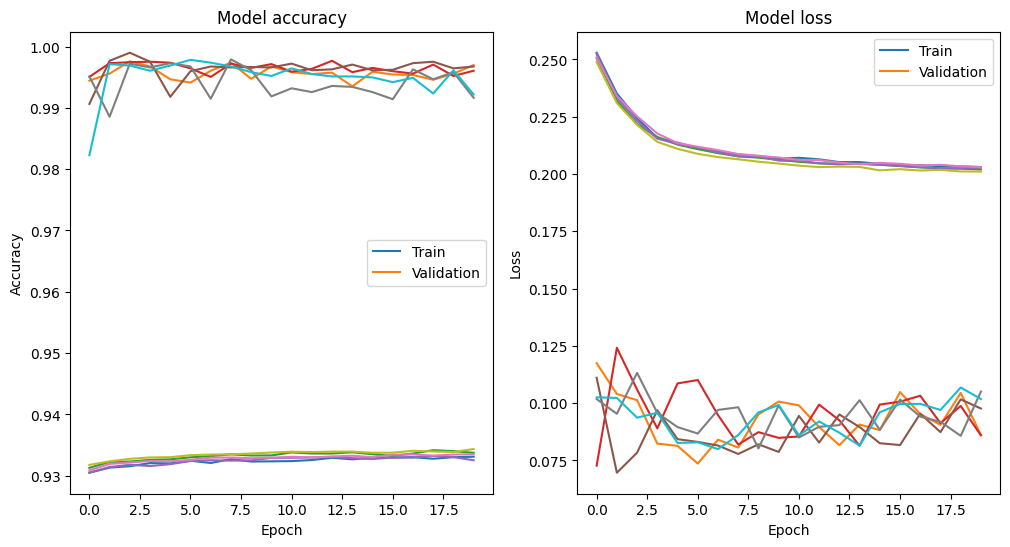

In [12]:
plt.figure(figsize=(12, 6))

for history in history_list:
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])

plt.show()